# Image Recognition with PCA - Lab

## Introduction

In this lab, you'll explore the classic MNIST dataset of handwritten digits. While not as large as the previous dataset on facial image recognition, it still provides a 64-dimensional dataset that is ripe for feature reduction.

## Objectives

In this lab you will: 

- Use PCA to discover the principal components with images 
- Use the principal components of  a dataset as features in a machine learning model 
- Calculate the time savings and performance gains of layering in PCA as a preprocessing step in machine learning pipelines 

## Load the data

Load the `load_digits` dataset from the `datasets` module of scikit-learn. 

In [1]:
# Load the dataset
from sklearn.datasets import load_digits

data = load_digits()
print(data.data.shape, data.target.shape)

(1797, 64) (1797,)


## Preview the dataset

Now that the dataset is loaded, display the first 20 images.

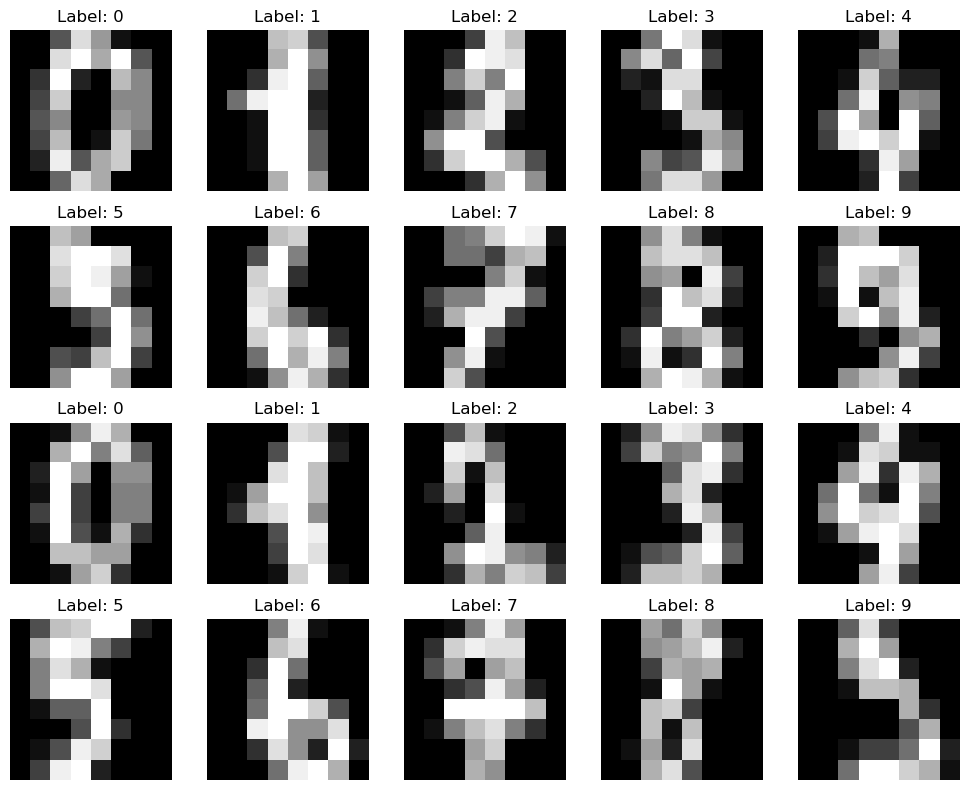

In [2]:
# Display the first 20 images 
import matplotlib.pyplot as plt

# Display the first 20 images
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))

for ax, image, label in zip(axes.flat, data.images[:20], data.target[:20]):
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()



## Baseline model

Now it's time to fit an initial baseline model. 

- Split the data into training and test sets. Set `random_state=22` 
- Fit a support vector machine to the dataset. Set `gamma='auto'` 
- Record the training time 
- Print the training and test accucary of the model 

In [3]:
# Split the data
from sklearn.model_selection import train_test_split

X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=22)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1437, 64) (360, 64) (1437,) (360,)


In [4]:
# Fit a naive model 
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
clf.fit(X_train, y_train)



DecisionTreeClassifier(random_state=42)

In [5]:
# Training and test accuracy
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, clf.predict(X_test))
print('Training Accuracy: {}\nTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0
Testing Accuracy: 0.8722222222222222


### Grid search baseline

Refine the initial model by performing a grid search to tune the hyperparameters. The two most important parameters to adjust are `'C'` and `'gamma'`. Once again, be sure to record the training time as well as the training and test accuracy.

In [6]:
# Your code here
# ⏰ Your code may take several minutes to run
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}

# Initialize the SVM classifier
svm_model = SVC()

# Initialize GridSearchCV with the SVM model and parameter grid
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1)

# Record the start time for training
start_time = time.time()

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Calculate the training time
training_time = time.time() - start_time

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


print(f"Training Time: {training_time:.4f} seconds")



Training Time: 18.5909 seconds


In [7]:
# Print the best parameters 
print("Best Hyperparameters:", best_params)



Best Hyperparameters: {'C': 10, 'gamma': 0.001}


In [8]:
# Print the training and test accuracy 
# Get the training and test accuracy of the best model
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)

print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.9944444444444445


## Compressing with PCA

Now that you've fit a baseline classifier, it's time to explore the impacts of using PCA as a preprocessing technique. To start, perform PCA on `X_train`. (Be sure to only fit PCA to `X_train`; you don't want to leak any information from the test set.) Also, don't reduce the number of features quite yet. You'll determine the number of features needed to account for 95% of the overall variance momentarily.

In [9]:
# Your code here
from sklearn.decomposition import PCA

# Initialize PCA with no reduction in the number of features
pca = PCA(n_components=None)

# Fit PCA to the training data
pca.fit(X_train)



PCA()

## Plot the explained variance versus the number of features

In order to determine the number of features you wish to reduce the dataset to, it is sensible to plot the overall variance accounted for by the first $n$ principal components. Create a graph of the variance explained versus the number of principal components.

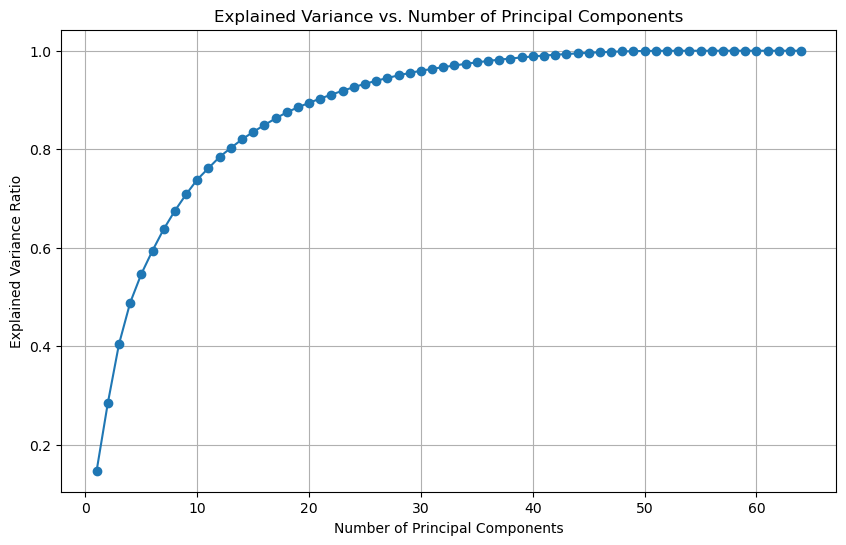

In [11]:
import numpy as np
# Fit PCA to X_train (just to retrieve the explained variance)
pca = PCA(n_components=None)
pca.fit(X_train)

# Get the cumulative explained variance ratio
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Create a plot of the explained variance versus the number of principal components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()


## Determine the number of features to capture 95% of the variance

Great! Now determine the number of features needed to capture 95% of the dataset's overall variance.

In [12]:

# Fit PCA to X_train (just to retrieve the explained variance)
pca = PCA(n_components=None)
pca.fit(X_train)

# Get the cumulative explained variance ratio
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed for 95% variance
num_features_for_95_percent_variance = np.argmax(explained_variance_ratio >= 0.95) + 1

print(f"Number of features to capture 95% of variance: {num_features_for_95_percent_variance}")



Number of features to capture 95% of variance: 29


## Subset the dataset to these principal components which capture 95% of the overall variance

Use your knowledge to reproject the dataset into a lower-dimensional space using PCA. 

In [13]:

# Fit PCA to X_train to get the principal components
pca = PCA(n_components=0.95)  # Keep components that explain 95% of variance
X_train_reduced = pca.fit_transform(X_train)

# Transform X_test using the same PCA model
X_test_reduced = pca.transform(X_test)

# Print the shape of the reduced datasets
print("Shape of X_train_reduced:", X_train_reduced.shape)
print("Shape of X_test_reduced:", X_test_reduced.shape)


Shape of X_train_reduced: (1437, 29)
Shape of X_test_reduced: (360, 29)


## Refit a model on the compressed dataset

Now, refit a classification model to the compressed dataset. Be sure to time the required training time, as well as the test and training accuracy.

In [14]:
from sklearn.tree import DecisionTreeClassifier
import time

# Initialize the Decision Tree classifier
clf_reduced = DecisionTreeClassifier(random_state=42)

# Record the start time for training on the reduced dataset
start_time = time.time()

# Fit the classifier to the reduced training data
clf_reduced.fit(X_train_reduced, y_train)

# Calculate the training time on the reduced dataset
training_time_reduced = time.time() - start_time

# Get the training and test accuracy on the reduced dataset
train_accuracy_reduced = clf_reduced.score(X_train_reduced, y_train)
test_accuracy_reduced = clf_reduced.score(X_test_reduced, y_test)

print("Training Accuracy on Reduced Dataset: {:.4f}".format(train_accuracy_reduced))
print("Test Accuracy on Reduced Dataset: {:.4f}".format(test_accuracy_reduced))
print("Training Time on Reduced Dataset: {:.4f} seconds".format(training_time_reduced))


Training Accuracy on Reduced Dataset: 1.0000
Test Accuracy on Reduced Dataset: 0.8611
Training Time on Reduced Dataset: 0.0348 seconds


### Grid search

Finally, use grid search to find optimal hyperparameters for the classifier on the reduced dataset. Be sure to record the time required to fit the model, the optimal hyperparameters and the test and train accuracy of the resulting model.

In [15]:
# Your code here
# ⏰ Your code may take several minutes to run

# Define the parameter grid to search
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 10, 20, 30, 40, 50]}

# Initialize the Decision Tree classifier
clf_reduced = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV with the classifier and parameter grid
grid_search_reduced = GridSearchCV(clf_reduced, param_grid, cv=5, n_jobs=-1)

# Record the start time for grid search training on the reduced dataset
start_time = time.time()

# Fit GridSearchCV to the reduced training data
grid_search_reduced.fit(X_train_reduced, y_train)

# Calculate the training time on the reduced dataset with grid search
training_time_grid_reduced = time.time() - start_time

# Get the best hyperparameters and the best model from grid search
best_params_reduced = grid_search_reduced.best_params_
best_model_reduced = grid_search_reduced.best_estimator_


print("Training Time on Reduced Dataset (GridSearchCV): {:.4f} seconds".format(training_time_grid_reduced))


Training Time on Reduced Dataset (GridSearchCV): 1.9070 seconds


In [16]:
# Print the best parameters 
print("Best Hyperparameters on Reduced Dataset:", best_params_reduced)


Best Hyperparameters on Reduced Dataset: {'criterion': 'gini', 'max_depth': None}


In [17]:
# Print the training and test accuracy 
train_acc = best_model_reduced.score(X_train_reduced, y_train)
test_acc = best_model_reduced.score(X_test_reduced, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.8611111111111112


## Summary

Well done! In this lab, you employed PCA to reduce a high dimensional dataset. With this, you observed the potential cost benefits required to train a model and performance gains of the model itself.